In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import te2rules
import pickle
from te2rules.explainer import ModelExplainer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import r_regression, f_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, fbeta_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

Matplotlib is building the font cache; this may take a moment.


In [2]:
%load_ext autoreload
%autoreload 2
SEED = 83
np.random.seed(SEED)

# 1. Data Collection

In [3]:
df_climate = pd.read_csv('./dataset/climate_data.csv')
df_station = pd.read_csv('./dataset/station_detail.csv')
df_satellite = pd.read_csv('./dataset/satellite_data.csv')
df_climate.shape, df_satellite.shape

((580689, 12), (688543, 15))

# 2. Feature Engineering

In [4]:
station_id = df_station['station_id'].loc[(
    (df_station['province_id'] == 20) |
    (df_station['province_id'] == 21) |
    (df_station['province_id'] == 22) |
    (df_station['province_id'] == 23) |
    (df_station['province_id'] == 34) )]

df_station = df_station[df_station['station_id'].isin(station_id)]


In [5]:
df_climate = pd.merge(df_climate, df_station, on='station_id')
df_climate['date'] = pd.to_datetime(df_climate['date'], format='%d-%m-%Y').dt.strftime('%Y-%m-%d')
df_climate['ddd_car'] = df_climate['ddd_car'].str.strip()
df_climate['ddd_car'] = df_climate['ddd_car'].replace(df_climate["ddd_car"].unique(), np.arange(0, len(df_climate["ddd_car"].unique())))
df_climate = df_climate.dropna(axis=0, how='any')
print('Shape:', df_climate.shape)
df_climate.head()

Shape: (58193, 18)


C:\Users\ariaw\AppData\Local\Temp\ipykernel_19752\1076436852.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_climate['ddd_car'] = df_climate['ddd_car'].replace(df_climate["ddd_car"].unique(), np.arange(0, len(df_climate["ddd_car"].unique())))


,date,Tn,Tx,Tavg,RH_avg,RR,ss,ff_x,ddd_x,ff_avg,ddd_car,station_id,station_name,region_name,latitude,longitude,region_id,province_id
0,2010-01-01,24.2,32.6,28.2,80.0,0.0,7.7,4.0,100.0,2.0,0.0,96503,Stasiun Meteorologi Nunukan,Kab. Nunukan,4.13,117.67,505,34
1,2010-01-02,23.5,32.5,28.4,81.0,0.0,6.7,4.0,100.0,2.0,0.0,96503,Stasiun Meteorologi Nunukan,Kab. Nunukan,4.13,117.67,505,34
2,2010-01-03,23.2,33.4,28.6,83.0,0.0,6.4,3.0,330.0,2.0,0.0,96503,Stasiun Meteorologi Nunukan,Kab. Nunukan,4.13,117.67,505,34
3,2010-01-04,24.4,33.8,28.6,80.0,0.0,8.0,4.0,340.0,3.0,1.0,96503,Stasiun Meteorologi Nunukan,Kab. Nunukan,4.13,117.67,505,34
4,2010-01-05,24.6,33.0,28.1,77.0,0.0,8.0,4.0,350.0,3.0,1.0,96503,Stasiun Meteorologi Nunukan,Kab. Nunukan,4.13,117.67,505,34


In [6]:
df_climate = df_climate.drop(
    df_climate[(df_climate['Tx'] <= 17) |
    (df_climate['Tn'] <= 17) |
    (df_climate['Tavg'] <= 17) |
    (df_climate['ff_x'] >= 17) |
    (df_climate['ss'] >= 12) |
    (df_climate['ddd_x'] == 888)].index)

In [7]:
df_satellite = df_satellite[df_satellite['confidence'] >= 80]
df_satellite = df_satellite[df_satellite['type'] == 0]
df_satellite = df_satellite[df_satellite['daynight'] == 'D']
df_satellite.shape

(116376, 15)

In [8]:
kalimantan = {"long" : [109.49, 117.97], "lat" : [-3.76225, 4.43000]}
condition = (df_satellite["latitude"] <= kalimantan["lat"][1]) & (df_satellite["latitude"] >= kalimantan["lat"][0]) & \
            (df_satellite["longitude"] <= kalimantan["long"][1]) & (df_satellite["longitude"] >= kalimantan["long"][0])
df_satellite = df_satellite[condition].copy()
df_satellite = df_satellite.drop_duplicates(subset=['latitude','longitude', 'acq_date', 'acq_time'])
df_satellite = df_satellite.rename(columns={'acq_date': 'date', 'acq_time': 'time'})
df_satellite = df_satellite.dropna(axis=0, how="any")

In [9]:
df_climate = df_climate[['date', 'station_id', 'Tx', 'Tn', 'Tavg', 'RH_avg', 'RR', 'ss', 'ff_x', 'ff_avg', 'ddd_x', 'ddd_car']]
df_satellite = df_satellite[['latitude', 'longitude', 'date', 'time', 'frp']]

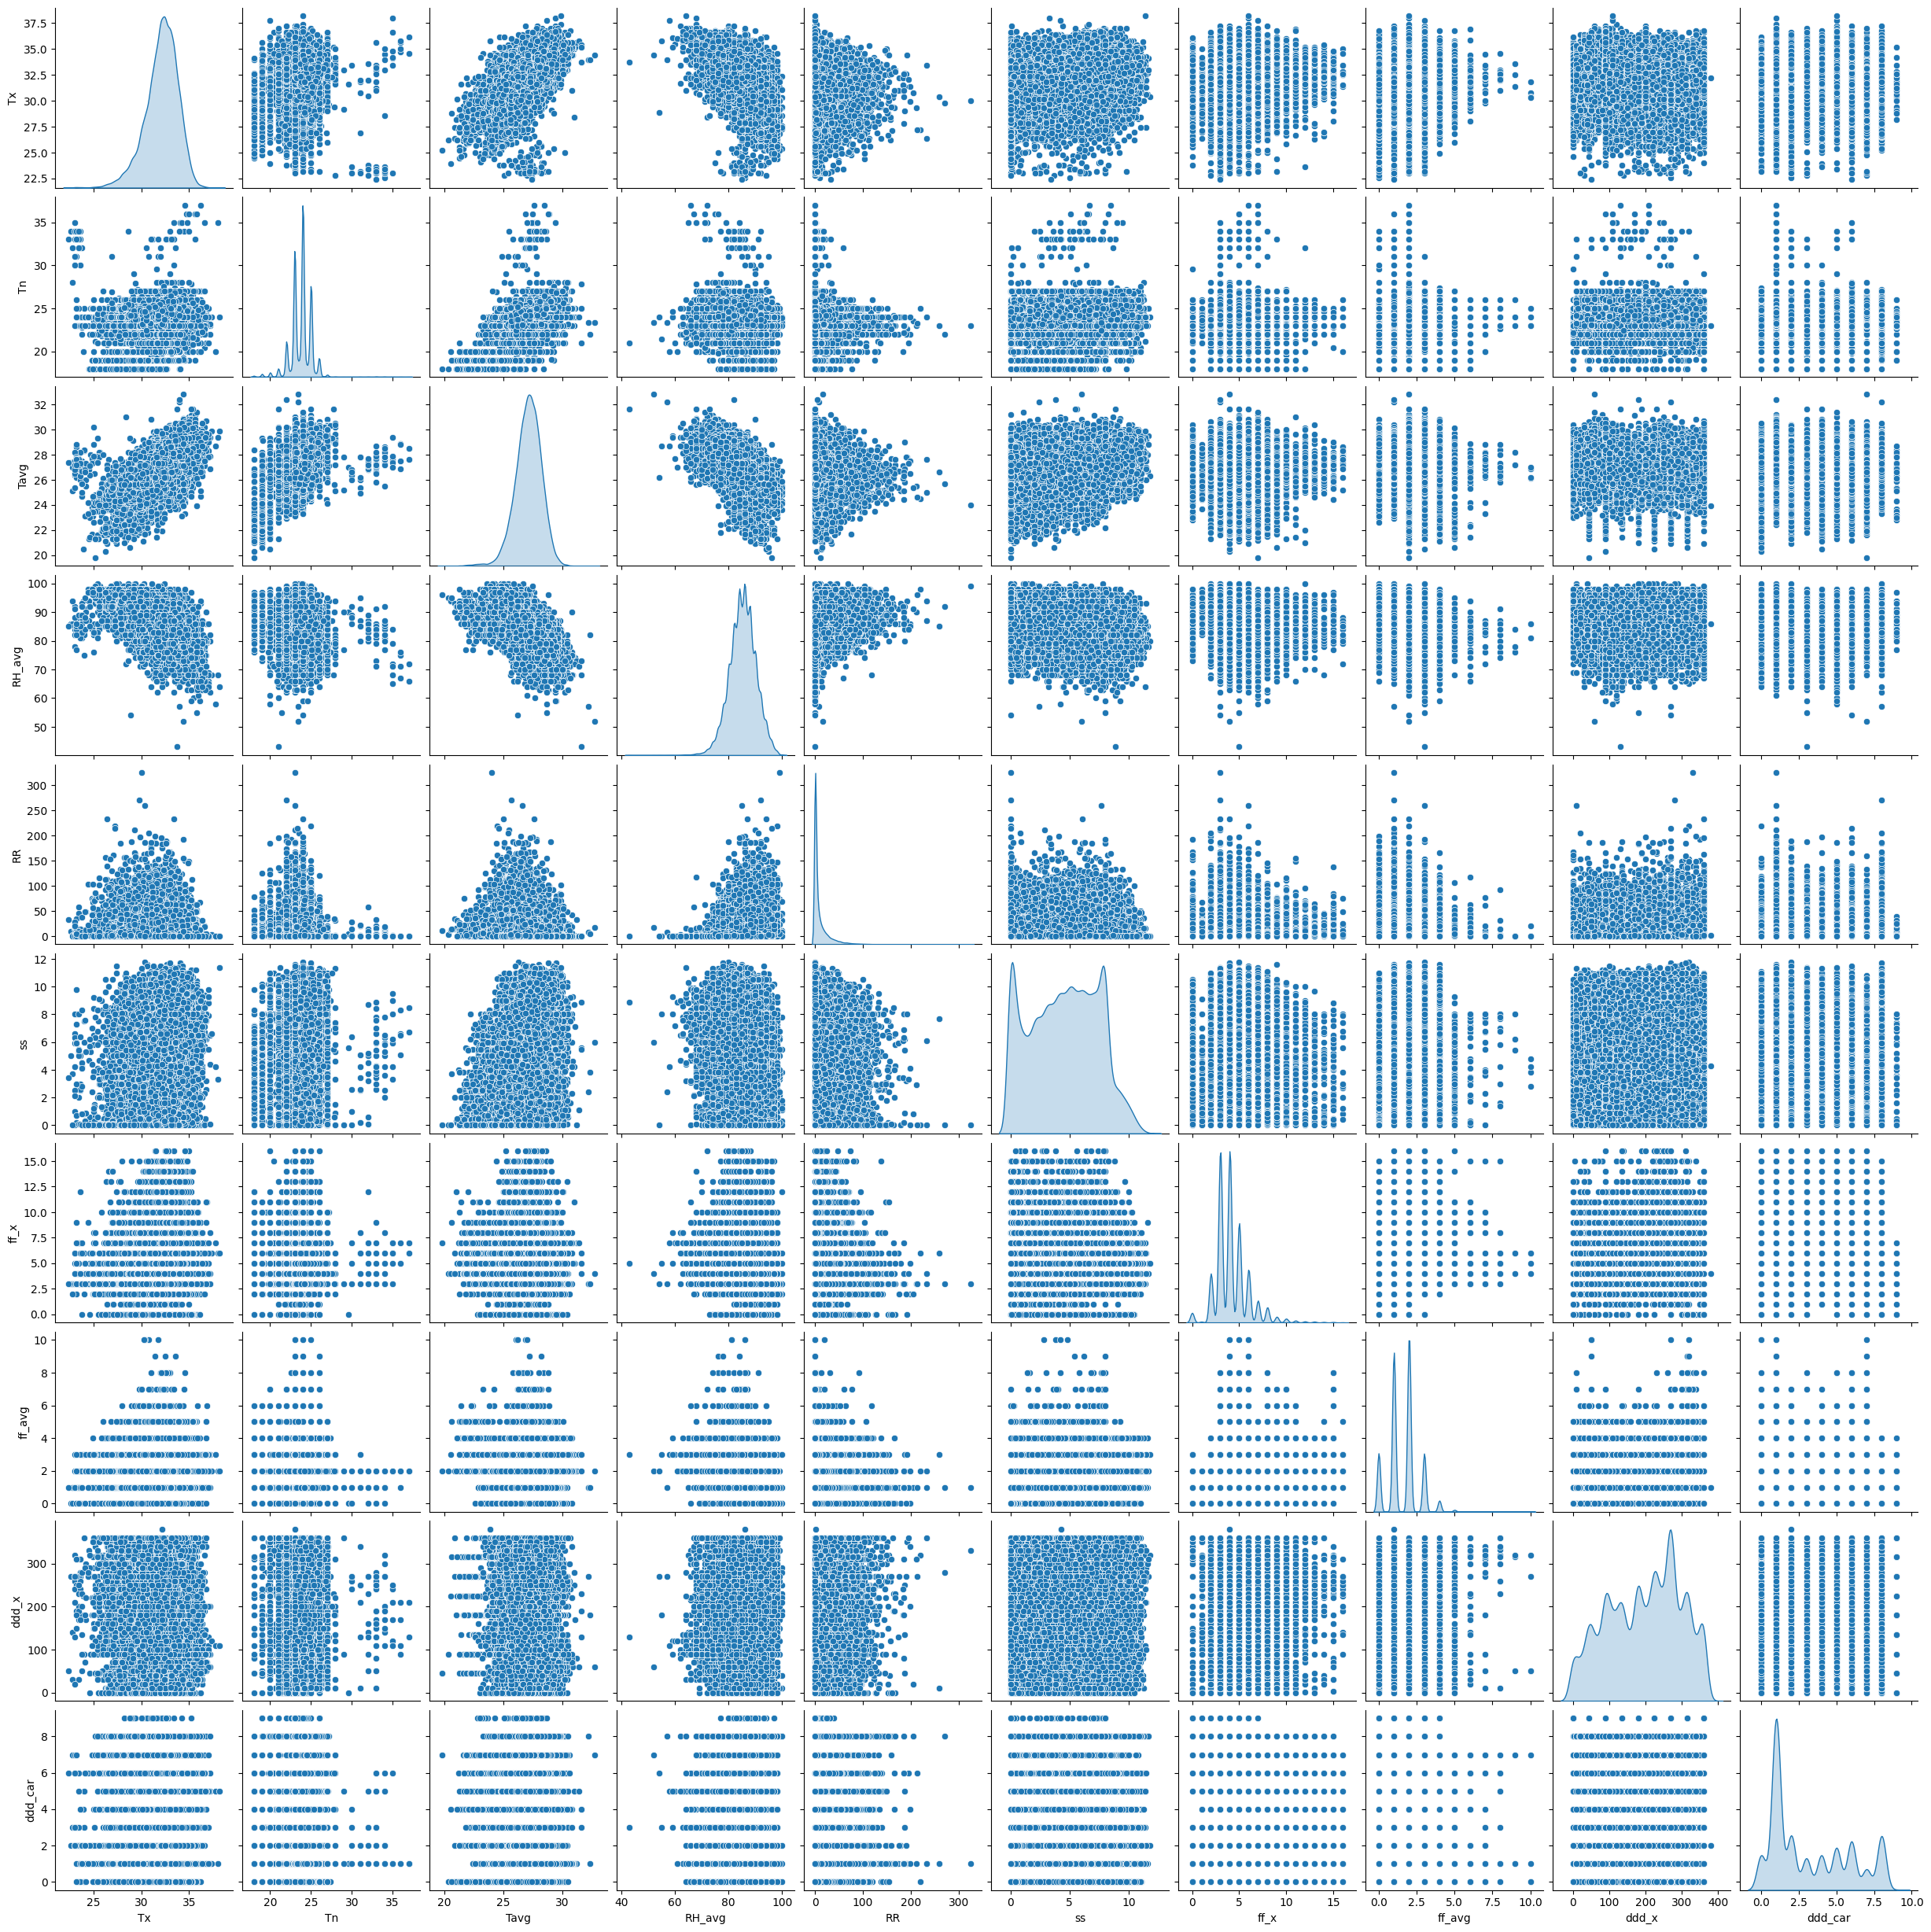

In [10]:
sns.pairplot(df_climate[['Tx', 'Tn', 'Tavg', 'RH_avg', 'RR', 'ss', 'ff_x', 'ff_avg', 'ddd_x', 'ddd_car']], diag_kind='kde')
plt.show()

In [11]:
station_dist_matrix = np.linalg.norm(df_station[['latitude', 'longitude']].values[:, np.newaxis] - df_station[['latitude', 'longitude']].values, axis=-1)
np.fill_diagonal(station_dist_matrix, np.inf)
max_radius = np.max(np.min(station_dist_matrix, axis=-1)) / 2
print('Maximum radius (i = 0):', max_radius, 'degree')
print('Maximum radius (i = 0):', max_radius * 111.32, 'km')

Maximum radius (i = 0): 0.9814530044785573 degree
Maximum radius (i = 0): 109.255348458553 km


In [12]:
dist_station_to_spot = np.linalg.norm(df_satellite[['latitude', 'longitude']].values[:, np.newaxis] - df_station[['latitude', 'longitude']].values, axis=-1)
closest_station_to_spot = np.argmin(dist_station_to_spot, axis=-1)
df_satellite['station_id'] = df_station['station_id'].iloc[closest_station_to_spot].values
df_satellite['closest_station_distance'] = np.min(dist_station_to_spot, axis=-1)
df_satellite.head()

,latitude,longitude,date,time,frp,station_id,closest_station_distance
59,1.6507,117.1702,2010-01-05,526,36.2,96529,0.560718
61,1.6146,117.1759,2010-01-05,526,72.6,96529,0.590313
65,1.2927,117.5666,2010-01-05,526,45.8,96529,0.863204
196,-1.1706,116.8073,2010-01-17,549,33.2,96633,0.128785
198,-1.9649,114.1318,2010-01-17,549,24.4,96655,0.313253


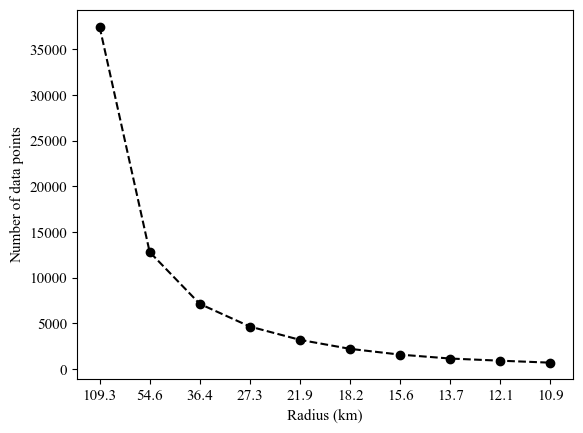

In [13]:
num_data = []
for i in range(1, 11):
    num_data.append(df_satellite[df_satellite['closest_station_distance'] <= max_radius / (i)].shape[0])
fig, ax = plt.subplots()
ax.plot(num_data, c='k', linestyle='--', marker='o')
ticks = [str(round(max_radius * 111.32 / (i),1)) for i in range(1, 11)]
ax.set_xticks(range(10))
ax.set_xticklabels(ticks, fontname='Times New Roman', fontsize=11)
ax.set_xlabel('Radius (km)', fontname='Times New Roman', fontsize=11)
ax.set_ylabel('Number of data points', fontname='Times New Roman', fontsize=11)
plt.yticks(fontname='Times New Roman', fontsize=11)
# plt.ylim(0, 40000)
plt.show()

In [14]:
df = df_satellite[df_satellite['closest_station_distance'] <= max_radius / 3].copy()
df_satellite.shape, df.shape

((46641, 7), (7137, 7))

In [15]:
df = df[['station_id', 'closest_station_distance', 'latitude', 'longitude', 'date', 'time', 'frp']]
df = pd.merge(df, df_climate, on=['station_id', 'date'], how='right')

In [16]:
df['frp'] = df['frp'].fillna(0)
df = df.sort_values(by='closest_station_distance')
df = df.drop_duplicates(subset=['latitude', 'longitude', 'date'], keep='first')
df = df[(
    (df['Tx'] >= 10) & 
    (df['Tn'] >= 10) & 
    (df['Tavg'] >= 10) & 
    (df['RH_avg'] >= 10) & 
    (df['ss'] >= 1))]
df = df.drop(columns=["station_id", "time", "ddd_car", "ddd_x"])
df['frp_group'] = df['frp'].apply(lambda x: 1 if x > 0 else 0)
df.shape

(6367, 14)

In [17]:
df['frp_group'].value_counts(), df['frp_group'].value_counts(normalize=True)

(frp_group
 0    3310
 1    3057
 Name: count, dtype: int64,
 frp_group
 0    0.519868
 1    0.480132
 Name: proportion, dtype: float64)

# 3. Feature Selection

In [18]:
X = df[['Tx', 'Tn', 'Tavg', 'RH_avg', 'RR', 'ss', 'ff_x', 'ff_avg']]
y = df[['frp_group', 'frp']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [19]:
p_reg = np.abs(r_regression(X, y['frp']))
pd.Series(p_reg, index=X.columns).sort_values(ascending=False)

Tx        0.289317
RH_avg    0.250616
Tn        0.181359
RR        0.130405
ss        0.093403
ff_avg    0.076469
ff_x      0.071429
Tavg      0.060653
dtype: float64

In [20]:
from sklearn.ensemble import RandomForestRegressor

tree_reg = RandomForestRegressor(max_depth=5, random_state=SEED)
tree_reg.fit(X, y['frp'])
pd.Series(tree_reg.feature_importances_, index=X.columns).sort_values(ascending=False)

Tx        0.394387
Tn        0.181624
RH_avg    0.106135
Tavg      0.105221
ss        0.079722
ff_avg    0.060015
ff_x      0.047754
RR        0.025140
dtype: float64

In [21]:
feature_df = pd.DataFrame(np.abs(p_reg), index=X.columns, columns=['p-value'])
feature_df = pd.concat([feature_df, pd.DataFrame(tree_reg.feature_importances_, index=X.columns, columns=['importance'])], axis=1)
feature_df['objective value'] = (feature_df['importance'] - feature_df['importance'].min()) / (feature_df['importance'].max() - feature_df['importance'].min())
feature_df = feature_df.sort_values(by='objective value', ascending=False)
group = {'T': ['Tx', 'Tn', 'Tavg'], 'ff': ['ff_x', 'ff_avg'], 'RH': ['RH_avg'], 'RR': ['RR'], 'ss': ['ss']}
selected_features = []
for key, value in group.items():
    group_features = feature_df.loc[value]
    max_feature = group_features['objective value'].idxmax()
    selected_features.append(max_feature)

print('Selected features:', selected_features)
feature_df

Selected features: ['Tx', 'ff_avg', 'RH_avg', 'RR', 'ss']


,p-value,importance,objective value
Tx,0.289317,0.394387,1.000000
Tn,0.181359,0.181624,0.423792
RH_avg,0.250616,0.106135,0.219352
Tavg,0.060653,0.105221,0.216877
ss,0.093403,0.079722,0.147820
ff_avg,0.076469,0.060015,0.094449
ff_x,0.071429,0.047754,0.061242
RR,0.130405,0.025140,0.000000


# 4. Modelling

In [22]:
x_train_norm = X_train_scaled[:, [X.columns.get_loc(i) for i in selected_features]]
x_test_norm = X_test_scaled[:, [X.columns.get_loc(i) for i in selected_features]]

## Base Model

In [23]:
base_model_1 = np.ones_like(y_test['frp_group'])
base_model_2 = np.zeros_like(y_test['frp_group'])
base_model_3 = np.random.choice([0, 1], size=len(y_test['frp_group']), p=[0.5, 0.5])
base_model_4 = np.random.choice([0, 1], size=len(y_test['frp_group']), p=[1-np.mean(y_train['frp_group']), np.mean(y_train['frp_group'])])

print('Base model 1 classification report:')
print(classification_report(y_test['frp_group'], base_model_1, zero_division=0))

print('Base model 2 classification report:')
print(classification_report(y_test['frp_group'], base_model_2, zero_division=0))

print('Base model 3 classification report:')
print(classification_report(y_test['frp_group'], base_model_3, zero_division=0))

print('Base model 4 classification report:')
print(classification_report(y_test['frp_group'], base_model_4, zero_division=0))

base_model_df = pd.DataFrame({
                                'accuracy': [accuracy_score(y_test['frp_group'], base_model_1),
                                             accuracy_score(y_test['frp_group'], base_model_2),
                                             accuracy_score(y_test['frp_group'], base_model_3),
                                             accuracy_score(y_test['frp_group'], base_model_4)],
                                'precision': [precision_score(y_test['frp_group'], base_model_1, zero_division=0),
                                              precision_score(y_test['frp_group'], base_model_2, zero_division=0),
                                              precision_score(y_test['frp_group'], base_model_3, zero_division=0),
                                              precision_score(y_test['frp_group'], base_model_4, zero_division=0)],
                                'recall': [recall_score(y_test['frp_group'], base_model_1, zero_division=0),
                                          recall_score(y_test['frp_group'], base_model_2, zero_division=0),
                                          recall_score(y_test['frp_group'], base_model_3, zero_division=0),
                                          recall_score(y_test['frp_group'], base_model_4, zero_division=0)],
                                'f1': [f1_score(y_test['frp_group'], base_model_1),
                                         f1_score(y_test['frp_group'], base_model_2),
                                         f1_score(y_test['frp_group'], base_model_3),
                                         f1_score(y_test['frp_group'], base_model_4)],
                                'roc_auc': [roc_auc_score(y_test['frp_group'], base_model_1),
                                            roc_auc_score(y_test['frp_group'], base_model_2),
                                            roc_auc_score(y_test['frp_group'], base_model_3),
                                            roc_auc_score(y_test['frp_group'], base_model_4)]
                                },
                              index=['Base model 1', 'Base model 2', 'Base model 3', 'Base model 4'])

base_model_df

Base model 1 classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       672
           1       0.47      1.00      0.64       602

    accuracy                           0.47      1274
   macro avg       0.24      0.50      0.32      1274
weighted avg       0.22      0.47      0.30      1274

Base model 2 classification report:
              precision    recall  f1-score   support

           0       0.53      1.00      0.69       672
           1       0.00      0.00      0.00       602

    accuracy                           0.53      1274
   macro avg       0.26      0.50      0.35      1274
weighted avg       0.28      0.53      0.36      1274

Base model 3 classification report:
              precision    recall  f1-score   support

           0       0.53      0.49      0.51       672
           1       0.47      0.51      0.49       602

    accuracy                           0.50      1274
   macro avg       0

,accuracy,precision,recall,f1,roc_auc
Base model 1,0.472527,0.472527,1.000000,0.641791,0.500000
Base model 2,0.527473,0.000000,0.000000,0.000000,0.500000
Base model 3,0.501570,0.474498,0.509967,0.491593,0.502007
Base model 4,0.478807,0.446918,0.433555,0.440135,0.476450


### 4.1. Decision Tree

In [24]:
dt = DecisionTreeClassifier(random_state=SEED)
params = {
    'max_depth': [3,4,5,6,7], 
    'min_samples_split': [2, 3, 4, 5, 6, 7], 
    'min_samples_leaf': [1, 2, 3, 4, 5], 
    'criterion': ['gini', 'entropy'], 
    'max_features': ['sqrt', 'log2']
}

grid_search_dt = GridSearchCV(dt, param_grid=params, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid_search_dt.fit(x_train_norm, y_train['frp_group'])

dt = grid_search_dt.best_estimator_

y_test_pred = dt.predict(x_test_norm)
y_train_pred = dt.predict(x_train_norm)

print('Accuracy score on train data: ', accuracy_score(y_train['frp_group'], y_train_pred))
print('Accuracy score on test data: ', accuracy_score(y_test['frp_group'], y_test_pred))

print('Confusion matrix on train data: \n', confusion_matrix(y_train['frp_group'], y_train_pred))
print('Confusion matrix on test data: \n', confusion_matrix(y_test['frp_group'], y_test_pred))

print('Classification report on train data: \n', classification_report(y_train['frp_group'], y_train_pred))
print('Classification report on test data: \n', classification_report(y_test['frp_group'], y_test_pred))


Fitting 5 folds for each of 600 candidates, totalling 3000 fits
Accuracy score on train data:  0.8548988808168074
Accuracy score on test data:  0.8273155416012559
Confusion matrix on train data: 
 [[2352  286]
 [ 453 2002]]
Confusion matrix on test data: 
 [[583  89]
 [131 471]]
Classification report on train data: 
               precision    recall  f1-score   support

           0       0.84      0.89      0.86      2638
           1       0.88      0.82      0.84      2455

    accuracy                           0.85      5093
   macro avg       0.86      0.85      0.85      5093
weighted avg       0.86      0.85      0.85      5093

Classification report on test data: 
               precision    recall  f1-score   support

           0       0.82      0.87      0.84       672
           1       0.84      0.78      0.81       602

    accuracy                           0.83      1274
   macro avg       0.83      0.82      0.83      1274
weighted avg       0.83      0.83      0.83 

In [45]:
grid_search_dt.best_params_

{'criterion': 'gini',
 'max_depth': 7,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 6}

### 4.2. Logistic Regression

In [25]:
lr = LogisticRegression(random_state=SEED)
params = {
    'C': [0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
    'max_iter': [100, 1000, 2500, 5000]
}

grid_search_lr = GridSearchCV(lr, param_grid=params, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid_search_lr.fit(x_train_norm, y_train['frp_group'])

lr = grid_search_lr.best_estimator_
y_test_pred = lr.predict(x_test_norm)
y_train_pred = lr.predict(x_train_norm)

print('Accuracy score on train data: ', accuracy_score(y_train['frp_group'], y_train_pred))
print('Accuracy score on test data: ', accuracy_score(y_test['frp_group'], y_test_pred))

print('Confusion matrix on train data: \n', confusion_matrix(y_train['frp_group'], y_train_pred))
print('Confusion matrix on test data: \n', confusion_matrix(y_test['frp_group'], y_test_pred))

print('Classification report on train data: \n', classification_report(y_train['frp_group'], y_train_pred))
print('Classification report on test data: \n', classification_report(y_test['frp_group'], y_test_pred))

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Accuracy score on train data:  0.8081680738268211
Accuracy score on test data:  0.7998430141287284
Confusion matrix on train data: 
 [[2148  490]
 [ 487 1968]]
Confusion matrix on test data: 
 [[544 128]
 [127 475]]
Classification report on train data: 
               precision    recall  f1-score   support

           0       0.82      0.81      0.81      2638
           1       0.80      0.80      0.80      2455

    accuracy                           0.81      5093
   macro avg       0.81      0.81      0.81      5093
weighted avg       0.81      0.81      0.81      5093

Classification report on test data: 
               precision    recall  f1-score   support

           0       0.81      0.81      0.81       672
           1       0.79      0.79      0.79       602

    accuracy                           0.80      1274
   macro avg       0.80      0.80      0.80      1274
weighted avg       0.80      0.80      0.80   

In [44]:
grid_search_lr.best_params_

{'C': 0.1, 'max_iter': 100, 'solver': 'liblinear'}

### 4.3. SVC

In [26]:
svc = SVC(random_state=SEED)
params = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['poly', 'rbf', 'sigmoid'],
    'degree': [1, 2, 3, 4]
}

grid_search_svc = GridSearchCV(svc, param_grid=params, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid_search_svc.fit(x_train_norm, y_train['frp_group'])

svc = grid_search_svc.best_estimator_

y_test_pred = svc.predict(x_test_norm)
y_train_pred = svc.predict(x_train_norm)

print('Accuracy score on train data: ', accuracy_score(y_train['frp_group'], y_train_pred))
print('Accuracy score on test data: ', accuracy_score(y_test['frp_group'], y_test_pred))

print('Confusion matrix on train data: \n', confusion_matrix(y_train['frp_group'], y_train_pred))
print('Confusion matrix on test data: \n', confusion_matrix(y_test['frp_group'], y_test_pred))

print('Classification report on train data: \n', classification_report(y_train['frp_group'], y_train_pred))
print('Classification report on test data: \n', classification_report(y_test['frp_group'], y_test_pred))


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Accuracy score on train data:  0.8768898488120951
Accuracy score on test data:  0.8563579277864992
Confusion matrix on train data: 
 [[2354  284]
 [ 343 2112]]
Confusion matrix on test data: 
 [[589  83]
 [100 502]]
Classification report on train data: 
               precision    recall  f1-score   support

           0       0.87      0.89      0.88      2638
           1       0.88      0.86      0.87      2455

    accuracy                           0.88      5093
   macro avg       0.88      0.88      0.88      5093
weighted avg       0.88      0.88      0.88      5093

Classification report on test data: 
               precision    recall  f1-score   support

           0       0.85      0.88      0.87       672
           1       0.86      0.83      0.85       602

    accuracy                           0.86      1274
   macro avg       0.86      0.86      0.86      1274
weighted avg       0.86      0.86      0.86   

In [43]:
grid_search_svc.best_params_

{'C': 100, 'degree': 1, 'kernel': 'rbf'}

### 4.4. KNN

In [27]:
knn = KNeighborsClassifier()

params = {
    'n_neighbors': [2, 3, 4],  
    'algorithm': ['ball_tree', 'kd_tree', 'brute'], 
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'leaf_size': [10, 20, 30, 40, 50],
}

grid_search_knn = GridSearchCV(knn, param_grid=params, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid_search_knn.fit(x_train_norm, y_train['frp_group'])

knn = grid_search_knn.best_estimator_
y_test_pred = knn.predict(x_test_norm)
y_train_pred = knn.predict(x_train_norm)

print('Accuracy score on train data: ', accuracy_score(y_train['frp_group'], y_train_pred))
print('Accuracy score on test data: ', accuracy_score(y_test['frp_group'], y_test_pred))

print('Confusion matrix on train data: \n', confusion_matrix(y_train['frp_group'], y_train_pred))
print('Confusion matrix on test data: \n', confusion_matrix(y_test['frp_group'], y_test_pred))

print('Classification report on train data: \n', classification_report(y_train['frp_group'], y_train_pred))
print('Classification report on test data: \n', classification_report(y_test['frp_group'], y_test_pred))

Fitting 5 folds for each of 135 candidates, totalling 675 fits
Accuracy score on train data:  0.9314745729432554
Accuracy score on test data:  0.8720565149136578
Confusion matrix on train data: 
 [[2413  225]
 [ 124 2331]]
Confusion matrix on test data: 
 [[558 114]
 [ 49 553]]
Classification report on train data: 
               precision    recall  f1-score   support

           0       0.95      0.91      0.93      2638
           1       0.91      0.95      0.93      2455

    accuracy                           0.93      5093
   macro avg       0.93      0.93      0.93      5093
weighted avg       0.93      0.93      0.93      5093

Classification report on test data: 
               precision    recall  f1-score   support

           0       0.92      0.83      0.87       672
           1       0.83      0.92      0.87       602

    accuracy                           0.87      1274
   macro avg       0.87      0.87      0.87      1274
weighted avg       0.88      0.87      0.87  

In [42]:
grid_search_knn.best_params_

{'algorithm': 'kd_tree',
 'leaf_size': 20,
 'metric': 'manhattan',
 'n_neighbors': 3}

### 4.5. Random Forest

In [28]:
rf = RandomForestClassifier(random_state=SEED)
params = {
    'max_depth': [3, 4, 5, 6, 7], 
    'min_samples_split': [2, 3, 4, 5, 6, 7], 
    'min_samples_leaf': [1, 2, 3, 4, 5], 
    'criterion': ['gini', 'entropy'], 
    'max_features': ['sqrt', 'log2']
}

grid_search_rf = GridSearchCV(rf, param_grid=params, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid_search_rf.fit(x_train_norm, y_train['frp_group'])

rf = grid_search_rf.best_estimator_

y_test_pred = rf.predict(x_test_norm)
y_train_pred = rf.predict(x_train_norm)

print('Accuracy score on train data: ', accuracy_score(y_train['frp_group'], y_train_pred))
print('Accuracy score on test data: ', accuracy_score(y_test['frp_group'], y_test_pred))

print('Confusion matrix on train data: \n', confusion_matrix(y_train['frp_group'], y_train_pred))
print('Confusion matrix on test data: \n', confusion_matrix(y_test['frp_group'], y_test_pred))

print('Classification report on train data: \n', classification_report(y_train['frp_group'], y_train_pred))
print('Classification report on test data: \n', classification_report(y_test['frp_group'], y_test_pred))

Fitting 5 folds for each of 600 candidates, totalling 3000 fits
Accuracy score on train data:  0.889063420380915
Accuracy score on test data:  0.8610675039246468
Confusion matrix on train data: 
 [[2393  245]
 [ 320 2135]]
Confusion matrix on test data: 
 [[590  82]
 [ 95 507]]
Classification report on train data: 
               precision    recall  f1-score   support

           0       0.88      0.91      0.89      2638
           1       0.90      0.87      0.88      2455

    accuracy                           0.89      5093
   macro avg       0.89      0.89      0.89      5093
weighted avg       0.89      0.89      0.89      5093

Classification report on test data: 
               precision    recall  f1-score   support

           0       0.86      0.88      0.87       672
           1       0.86      0.84      0.85       602

    accuracy                           0.86      1274
   macro avg       0.86      0.86      0.86      1274
weighted avg       0.86      0.86      0.86  

In [41]:
grid_search_rf.best_params_

{'criterion': 'gini',
 'max_depth': 7,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 3}

### 4.6. GB

In [29]:
gb = GradientBoostingClassifier(random_state=83)
params = {
    'max_depth': [3, 4, 5, 6, 7], 
    'min_samples_split': [2, 3, 4, 5, 6, 7], 
    'min_samples_leaf': [2, 3, 4, 5],
    'max_features': ['sqrt', 'log2']
}
grid_search_gb = GridSearchCV(gb, param_grid=params, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid_search_gb.fit(x_train_norm, y_train['frp_group'])

gb = grid_search_gb.best_estimator_

y_test_pred = gb.predict(x_test_norm)
y_train_pred = gb.predict(x_train_norm)

print('Accuracy score on train data: ', accuracy_score(y_train['frp_group'], y_train_pred))
print('Accuracy score on test data: ', accuracy_score(y_test['frp_group'], y_test_pred))

print('Confusion matrix on train data: \n', confusion_matrix(y_train['frp_group'], y_train_pred))
print('Confusion matrix on test data: \n', confusion_matrix(y_test['frp_group'], y_test_pred))

print('Classification report on train data: \n', classification_report(y_train['frp_group'], y_train_pred))
print('Classification report on test data: \n', classification_report(y_test['frp_group'], y_test_pred))

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Accuracy score on train data:  0.9568034557235421
Accuracy score on test data:  0.9034536891679749
Confusion matrix on train data: 
 [[2528  110]
 [ 110 2345]]
Confusion matrix on test data: 
 [[594  78]
 [ 45 557]]
Classification report on train data: 
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      2638
           1       0.96      0.96      0.96      2455

    accuracy                           0.96      5093
   macro avg       0.96      0.96      0.96      5093
weighted avg       0.96      0.96      0.96      5093

Classification report on test data: 
               precision    recall  f1-score   support

           0       0.93      0.88      0.91       672
           1       0.88      0.93      0.90       602

    accuracy                           0.90      1274
   macro avg       0.90      0.90      0.90      1274
weighted avg       0.90      0.90      0.90 

In [30]:
grid_search_gb.best_params_

{'max_depth': 7,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'min_samples_split': 2}

# 5. Evaluation

In [31]:
def objective_func(recall, precision, acc, F2):
    return (2 * recall + precision + acc + 2 * F2) / 6

eval_index = ['F2-score', 'Precision', 'Recall', 'Accuracy', 'Objective value']

model_train_pred = {
    'dt': dt.predict(x_train_norm),
    'lr': lr.predict(x_train_norm),
    'svc': svc.predict(x_train_norm),
    'knn': knn.predict(x_train_norm),
    'rf': rf.predict(x_train_norm),
    'gb': gb.predict(x_train_norm)
}

model_test_pred = {
    'dt': dt.predict(x_test_norm),
    'lr': lr.predict(x_test_norm),
    'svc': svc.predict(x_test_norm),
    'knn': knn.predict(x_test_norm),
    'rf': rf.predict(x_test_norm),
    'gb': gb.predict(x_test_norm)
}

eval_train_df = pd.DataFrame({
    'DT Model': [fbeta_score(y_train['frp_group'], model_train_pred['dt'], beta=2),
                    precision_score(y_train['frp_group'], model_train_pred['dt'], zero_division=0),
                    recall_score(y_train['frp_group'], model_train_pred['dt'], zero_division=0),
                    accuracy_score(y_train['frp_group'], model_train_pred['dt']),
                    objective_func(recall_score(y_train['frp_group'], model_train_pred['dt'], zero_division=0),
                                    precision_score(y_train['frp_group'], model_train_pred['dt'], zero_division=0),
                                    accuracy_score(y_train['frp_group'], model_train_pred['dt']),
                                    fbeta_score(y_train['frp_group'], model_train_pred['dt'], beta=2))],
    'LR Model': [fbeta_score(y_train['frp_group'], model_train_pred['lr'], beta=2),
                    precision_score(y_train['frp_group'], model_train_pred['lr'], zero_division=0),
                    recall_score(y_train['frp_group'], model_train_pred['lr'], zero_division=0),
                    accuracy_score(y_train['frp_group'], model_train_pred['lr']),
                    objective_func(recall_score(y_train['frp_group'], model_train_pred['lr'], zero_division=0),
                                    precision_score(y_train['frp_group'], model_train_pred['lr'], zero_division=0),
                                    accuracy_score(y_train['frp_group'], model_train_pred['lr']),
                                    fbeta_score(y_train['frp_group'], model_train_pred['lr'], beta=2))],
    'SVC Model': [fbeta_score(y_train['frp_group'], model_train_pred['svc'], beta=2),
                    precision_score(y_train['frp_group'], model_train_pred['svc'], zero_division=0),
                    recall_score(y_train['frp_group'], model_train_pred['svc'], zero_division=0),
                    accuracy_score(y_train['frp_group'], model_train_pred['svc']),
                    objective_func(recall_score(y_train['frp_group'], model_train_pred['svc'], zero_division=0),
                                    precision_score(y_train['frp_group'], model_train_pred['svc'], zero_division=0),
                                    accuracy_score(y_train['frp_group'], model_train_pred['svc']),
                                    fbeta_score(y_train['frp_group'], model_train_pred['svc'], beta=2))],
    'KNN Model': [fbeta_score(y_train['frp_group'], model_train_pred['knn'], beta=2),
                    precision_score(y_train['frp_group'], model_train_pred['knn'], zero_division=0),
                    recall_score(y_train['frp_group'], model_train_pred['knn'], zero_division=0),
                    accuracy_score(y_train['frp_group'], model_train_pred['knn']),
                    objective_func(recall_score(y_train['frp_group'], model_train_pred['knn'], zero_division=0),
                                    precision_score(y_train['frp_group'], model_train_pred['knn'], zero_division=0),
                                    accuracy_score(y_train['frp_group'], model_train_pred['knn']),
                                    fbeta_score(y_train['frp_group'], model_train_pred['knn'], beta=2))],
    'RF Model': [fbeta_score(y_train['frp_group'], model_train_pred['rf'], beta=2),
                    precision_score(y_train['frp_group'], model_train_pred['rf'], zero_division=0),
                    recall_score(y_train['frp_group'], model_train_pred['rf'], zero_division=0),
                    accuracy_score(y_train['frp_group'], model_train_pred['rf']),
                    objective_func(recall_score(y_train['frp_group'], model_train_pred['rf'], zero_division=0),
                                    precision_score(y_train['frp_group'], model_train_pred['rf'], zero_division=0),
                                    accuracy_score(y_train['frp_group'], model_train_pred['rf']),
                                    fbeta_score(y_train['frp_group'], model_train_pred['rf'], beta=2))],
    'GB Model': [fbeta_score(y_train['frp_group'], model_train_pred['gb'], beta=2),
                    precision_score(y_train['frp_group'], model_train_pred['gb'], zero_division=0),
                    recall_score(y_train['frp_group'], model_train_pred['gb'], zero_division=0),
                    accuracy_score(y_train['frp_group'], model_train_pred['gb']),
                    objective_func(recall_score(y_train['frp_group'], model_train_pred['gb'], zero_division=0),
                                    precision_score(y_train['frp_group'], model_train_pred['gb'], zero_division=0),
                                    accuracy_score(y_train['frp_group'], model_train_pred['gb']),
                                    fbeta_score(y_train['frp_group'], model_train_pred['gb'], beta=2))]
}, index=eval_index)

eval_test_df = pd.DataFrame({
    'DT Model': [fbeta_score(y_test['frp_group'], model_test_pred['dt'], beta=2),
                    precision_score(y_test['frp_group'], model_test_pred['dt'], zero_division=0),
                    recall_score(y_test['frp_group'], model_test_pred['dt'], zero_division=0),
                    accuracy_score(y_test['frp_group'], model_test_pred['dt']),
                    objective_func(recall_score(y_test['frp_group'], model_test_pred['dt'], zero_division=0),
                                    precision_score(y_test['frp_group'], model_test_pred['dt'], zero_division=0),
                                    accuracy_score(y_test['frp_group'], model_test_pred['dt']),
                                    fbeta_score(y_test['frp_group'], model_test_pred['dt'], beta=2))],
    'LR Model': [fbeta_score(y_test['frp_group'], model_test_pred['lr'], beta=2),
                    precision_score(y_test['frp_group'], model_test_pred['lr'], zero_division=0),
                    recall_score(y_test['frp_group'], model_test_pred['lr'], zero_division=0),
                    accuracy_score(y_test['frp_group'], model_test_pred['lr']),
                    objective_func(recall_score(y_test['frp_group'], model_test_pred['lr'], zero_division=0),
                                    precision_score(y_test['frp_group'], model_test_pred['lr'], zero_division=0),
                                    accuracy_score(y_test['frp_group'], model_test_pred['lr']),
                                    fbeta_score(y_test['frp_group'], model_test_pred['lr'], beta=2))],
    'SVC Model': [fbeta_score(y_test['frp_group'], model_test_pred['svc'], beta=2),
                    precision_score(y_test['frp_group'], model_test_pred['svc'], zero_division=0),
                    recall_score(y_test['frp_group'], model_test_pred['svc'], zero_division=0),
                    accuracy_score(y_test['frp_group'], model_test_pred['svc']),
                    objective_func(recall_score(y_test['frp_group'], model_test_pred['svc'], zero_division=0),
                                    precision_score(y_test['frp_group'], model_test_pred['svc'], zero_division=0),
                                    accuracy_score(y_test['frp_group'], model_test_pred['svc']),
                                    fbeta_score(y_test['frp_group'], model_test_pred['svc'], beta=2))],
    'KNN Model': [fbeta_score(y_test['frp_group'], model_test_pred['knn'], beta=2),
                    precision_score(y_test['frp_group'], model_test_pred['knn'], zero_division=0),
                    recall_score(y_test['frp_group'], model_test_pred['knn'], zero_division=0),
                    accuracy_score(y_test['frp_group'], model_test_pred['knn']),
                    objective_func(recall_score(y_test['frp_group'], model_test_pred['knn'], zero_division=0),
                                    precision_score(y_test['frp_group'], model_test_pred['knn'], zero_division=0),
                                    accuracy_score(y_test['frp_group'], model_test_pred['knn']),
                                    fbeta_score(y_test['frp_group'], model_test_pred['knn'], beta=2))],
    'RF Model': [fbeta_score(y_test['frp_group'], model_test_pred['rf'], beta=2),
                    precision_score(y_test['frp_group'], model_test_pred['rf'], zero_division=0),
                    recall_score(y_test['frp_group'], model_test_pred['rf'], zero_division=0),
                    accuracy_score(y_test['frp_group'], model_test_pred['rf']),
                    objective_func(recall_score(y_test['frp_group'], model_test_pred['rf'], zero_division=0),
                                    precision_score(y_test['frp_group'], model_test_pred['rf'], zero_division=0),
                                    accuracy_score(y_test['frp_group'], model_test_pred['rf']),
                                    fbeta_score(y_test['frp_group'], model_test_pred['rf'], beta=2))],
    'GB Model': [fbeta_score(y_test['frp_group'], model_test_pred['gb'], beta=2),
                    precision_score(y_test['frp_group'], model_test_pred['gb'], zero_division=0),
                    recall_score(y_test['frp_group'], model_test_pred['gb'], zero_division=0),
                    accuracy_score(y_test['frp_group'], model_test_pred['gb']),
                    objective_func(recall_score(y_test['frp_group'], model_test_pred['gb'], zero_division=0),
                                    precision_score(y_test['frp_group'], model_test_pred['gb'], zero_division=0),
                                    accuracy_score(y_test['frp_group'], model_test_pred['gb']),
                                    fbeta_score(y_test['frp_group'], model_test_pred['gb'], beta=2))]
}, index=eval_index)
    
eval_train_df = eval_train_df.round(2)
eval_test_df = eval_test_df.round(2)

eval_train_df

,DT Model,LR Model,SVC Model,KNN Model,RF Model,GB Model
F2-score,0.83,0.80,0.86,0.94,0.88,0.96
Precision,0.88,0.80,0.88,0.91,0.90,0.96
Recall,0.82,0.80,0.86,0.95,0.87,0.96
Accuracy,0.85,0.81,0.88,0.93,0.89,0.96
Objective value,0.84,0.80,0.87,0.94,0.88,0.96


In [32]:
eval_test_df

,DT Model,LR Model,SVC Model,KNN Model,RF Model,GB Model
F2-score,0.79,0.79,0.84,0.90,0.85,0.92
Precision,0.84,0.79,0.86,0.83,0.86,0.88
Recall,0.78,0.79,0.83,0.92,0.84,0.93
Accuracy,0.83,0.80,0.86,0.87,0.86,0.90
Objective value,0.80,0.79,0.84,0.89,0.85,0.91


# 6. Rules Analysis

In [33]:
best_model = eval_test_df.loc['Objective value'].idxmax()
best_model

'GB Model'

In [34]:
model_explainer = ModelExplainer(
    model=gb,
    feature_names=selected_features,
)

rules = model_explainer.explain(
    X=x_train_norm,
    y=y_train_pred
)

100%|██████████| 1738637/1738637 [05:14<00:00, 5523.69it/s]


In [35]:
print(str(len(rules)) + " rules found")

68 rules found


In [36]:
fidelity, positive_fidelity, negative_fidelity = model_explainer.get_fidelity()

print("The rules explain " + str(round(fidelity*100, 2)) + "% of the overall predictions of the model" )
print("The rules explain " + str(round(positive_fidelity*100, 2)) + "% of the positive predictions of the model" )
print("The rules explain " + str(round(negative_fidelity*100, 2)) + "% of the negative predictions of the model" )

The rules explain 94.84% of the overall predictions of the model
The rules explain 100.0% of the positive predictions of the model
The rules explain 90.03% of the negative predictions of the model


In [48]:
feature_names

['Tx', 'ff_avg', 'RH_avg', 'RR', 'ss']

In [50]:
feature_names = selected_features
new_rules = []
scaler_features = ['Tx', 'Tn', 'Tavg', 'RH_avg', 'RR', 'ss', 'ff_x', 'ff_avg']
for rule in rules:
    new_word = []
    for word in rule.split(' & '):
        text = word.split(' ')
        index = scaler_features.index(text[0])
        input_ = [0 for i in range(len(scaler_features))]
        input_[index] = text[-1]
        new_word.append(' '.join(text[:-1] + [str(round(scaler.inverse_transform(np.array(input_).reshape(1,-1))[0][index], 3))]))
    new_rules.append(' & '.join(new_word))

# Save Features, Model, etc.

In [51]:
pathlib.Path('model').mkdir(parents=True, exist_ok=True)
pathlib.Path('rules').mkdir(parents=True, exist_ok=True)
pathlib.Path('input/train').mkdir(parents=True, exist_ok=True)
pathlib.Path('input/test').mkdir(parents=True, exist_ok=True)
with pd.ExcelWriter('results.xlsx') as writer:
    eval_train_df.to_excel(writer, sheet_name='Train data')
    eval_test_df.to_excel(writer, sheet_name='Test data')
    feature_df.to_excel(writer, sheet_name='Feature Importance')
    base_model_df.to_excel(writer, sheet_name='Base Model')
    pd.DataFrame({'Fidelity': [fidelity, positive_fidelity, negative_fidelity]}).to_excel(writer, sheet_name='Fidelity')
with open('rules/rules.txt', 'w') as f:
    for i in range(len(new_rules)):
        f.write("Rule " + str(i+1) + ": " + str(new_rules[i]) + '\n')
with open('model/dt_model.pkl', 'wb') as f:
    pickle.dump(dt, f)
with open('model/lr_model.pkl', 'wb') as f:
    pickle.dump(lr, f)
with open('model/svc_model.pkl', 'wb') as f:
    pickle.dump(svc, f)
with open('model/knn_model.pkl', 'wb') as f:
    pickle.dump(knn, f)
with open('model/rf_model.pkl', 'wb') as f:
    pickle.dump(rf, f)
with open('model/gb_model.pkl', 'wb') as f:
    pickle.dump(gb, f)
with open('input/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
np.savetxt('input/selected_features.txt', selected_features, fmt='%s', delimiter=',')
np.savetxt('input/train/X_train.txt', X_train.values, fmt='%s', delimiter=',')
np.savetxt('input/test/X_test.txt', X_test.values, fmt='%s', delimiter=',')
np.savetxt('input/train/y_train.txt', y_train.values, fmt='%s', delimiter=',')
np.savetxt('input/test/y_test.txt', y_test.values, fmt='%s', delimiter=',')
np.savetxt('input/X.txt', X.values, fmt='%s', delimiter=',')
np.savetxt('input/y.txt', y.values, fmt='%s', delimiter=',')

In [40]:
with open('README.md', 'w') as f:
    f.write(f'''
# Vegetation Fire Prediction

## Getting Started
To run the project, you need to install the required libraries using the following command:
```
pip install -r requirements.txt
```
## Usage
To see the results of the project, you can see it in the: `model.ipynb` file.

---

## Introduction
This project aims to predict vegetation fires in Kalimantan using machine learning models. The dataset used in this project is a combination of climate data and satellite data, which are from BMKG Indonesia and NASA MODIS C61. The project uses the FRP as the target variable and the climate data as the features. The project uses machine learning models to predict the occurrence of vegetation fires.

## Dataset
The dataset consists of two main dataframes, the climate data and the satellite data. The climate data consists of the following columns:
- date: the date of the data
- station_id: the station id
- Tx: maximum temperature
- Tn: minimum temperature
- Tavg: average temperature
- RH_avg: average relative humidity
- RR: rainfall
- ss: sunshine duration
- ff_x: maximum wind speed
- ff_avg: average wind speed
- ddd_x: maximum wind direction
- ddd_car: wind direction in cardinal direction

The satellite data consists of the following columns:
- latitude: the latitude of the fire
- longitude: the longitude of the fire
- date: the date of the data
- time: the time of the data
- frp: the fire radiative power

## Data Preprocessing
The data is preprocessed by removing missing values and filtering the data based on the following conditions:
- The temperature is greater than 17 degrees Celsius
- The wind speed is less than 17 m/s
- The sunshine duration is greater than 1 hour
- The wind direction is not 888

The data is then filtered based on the location of the fire, which is in Kalimantan. The data is then merged based on the station id and the date. The data is then split into training and testing data.

## Feature Selection
The feature selection is done using the following methods:
- Pearson Correlation
- Random Forest Feature Importance

The selected features are:
{', '.join(selected_features)}

## Model Selection
The following models are used in this project:
- Decision Tree
- Logistic Regression
- Support Vector Machine
- K-Nearest Neighbors
- Random Forest
- Gradient Boosting

The models are trained using the training data and evaluated using the testing data. The best model is selected based on the objective function, which is a combination of the F2-score, precision, recall, and accuracy.

## Model Explanation
The best model is explained using rule-based explanation TE2Rules.
The rules are written in the <a href="rules/rules.txt">rules.txt</a> file. The rules explain the model's predictions and show the relationship between the features and the target variable.

## Results
### Training data
---
| Model | F2-score | Precision | Recall | Accuracy | Objective value |
| --- | --- | --- | --- | --- | --- |
| Decision Tree | {eval_train_df['DT Model'].iloc[0]} | {eval_train_df['DT Model'].iloc[1]} | {eval_train_df['DT Model'].iloc[2]} | {eval_train_df['DT Model'].iloc[3]} | {eval_train_df['DT Model'].iloc[4]} |
| Logistic Regression | {eval_train_df['LR Model'].iloc[0]} | {eval_train_df['LR Model'].iloc[1]} | {eval_train_df['LR Model'].iloc[2]} | {eval_train_df['LR Model'].iloc[3]} | {eval_train_df['LR Model'].iloc[4]} |
| Support Vector Machine | {eval_train_df['SVC Model'].iloc[0]} | {eval_train_df['SVC Model'].iloc[1]} | {eval_train_df['SVC Model'].iloc[2]} | {eval_train_df['SVC Model'].iloc[3]} | {eval_train_df['SVC Model'].iloc[4]} |
| K-Nearest Neighbors | {eval_train_df['KNN Model'].iloc[0]} | {eval_train_df['KNN Model'].iloc[1]} | {eval_train_df['KNN Model'].iloc[2]} | {eval_train_df['KNN Model'].iloc[3]} | {eval_train_df['KNN Model'].iloc[4]} |
| Random Forest | {eval_train_df['RF Model'].iloc[0]} | {eval_train_df['RF Model'].iloc[1]} | {eval_train_df['RF Model'].iloc[2]} | {eval_train_df['RF Model'].iloc[3]} | {eval_train_df['RF Model'].iloc[4]} |
| Gradient Boosting | {eval_train_df['GB Model'].iloc[0]} | {eval_train_df['GB Model'].iloc[1]} | {eval_train_df['GB Model'].iloc[2]} | {eval_train_df['GB Model'].iloc[3]} | {eval_train_df['GB Model'].iloc[4]} |

### Testing data
---
| Model | F2-score | Precision | Recall | Accuracy | Objective value |
| --- | --- | --- | --- | --- | --- |
| Decision Tree | {eval_test_df['DT Model'].iloc[0]} | {eval_test_df['DT Model'].iloc[1]} | {eval_test_df['DT Model'].iloc[2]} | {eval_test_df['DT Model'].iloc[3]} | {eval_test_df['DT Model'].iloc[4]} |
| Logistic Regression | {eval_test_df['LR Model'].iloc[0]} | {eval_test_df['LR Model'].iloc[1]} | {eval_test_df['LR Model'].iloc[2]} | {eval_test_df['LR Model'].iloc[3]} | {eval_test_df['LR Model'].iloc[4]} |
| Support Vector Machine | {eval_test_df['SVC Model'].iloc[0]} | {eval_test_df['SVC Model'].iloc[1]} | {eval_test_df['SVC Model'].iloc[2]} | {eval_test_df['SVC Model'].iloc[3]} | {eval_test_df['SVC Model'].iloc[4]} |
| K-Nearest Neighbors | {eval_test_df['KNN Model'].iloc[0]} | {eval_test_df['KNN Model'].iloc[1]} | {eval_test_df['KNN Model'].iloc[2]} | {eval_test_df['KNN Model'].iloc[3]} | {eval_test_df['KNN Model'].iloc[4]} |
| Random Forest | {eval_test_df['RF Model'].iloc[0]} | {eval_test_df['RF Model'].iloc[1]} | {eval_test_df['RF Model'].iloc[2]} | {eval_test_df['RF Model'].iloc[3]} | {eval_test_df['RF Model'].iloc[4]} |
| Gradient Boosting | {eval_test_df['GB Model'].iloc[0]} | {eval_test_df['GB Model'].iloc[1]} | {eval_test_df['GB Model'].iloc[2]} | {eval_test_df['GB Model'].iloc[3]} | {eval_test_df['GB Model'].iloc[4]} |

The best model is GB Model. We found 68 rules that explain the model.

The complete results of the project are written in the <a href="results.xlsx">results.xlsx</a> file.

## Conclusion
The project aims to predict vegetation fires in Kalimantan using machine learning models. The best model is selected based on the objective function, which is a {best_model.split(' ')[0]} model. The model is explained using rule-based explanation and fidelity. The results show that the model can predict vegetation fires with high accuracy.
''')